In [85]:
%matplotlib inline
from IPython.display import display
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from scipy.stats import ttest_ind
import seaborn as sns
from lending_club.loan_prediction.data_transformer import DataTransformer
from lending_club.utils.chi2 import compute_risk_ratio,chi2_stats




In [ ]:
la = DataTransformer()

## Loan Status Percentages by State##

In [33]:
status_counts = la.original_data[["addr_state","loan_status"]].groupby(["addr_state","loan_status"]).size().unstack().fillna(0)
norm_status_counts = status_counts.div(status_counts.sum(axis=1),axis=0)
norm_status_counts.head()

loan_status,Charged Off,Current,Default,Fully Paid,In Grace Period,Late (16-30 days),Late (31-120 days)
addr_state,,,,,,,
AK,0.089099,0.646751,0.000000,0.226415,0.014675,0.004193,0.018868
AL,0.094258,0.659248,0.000000,0.200486,0.014214,0.005424,0.026370
AR,0.085343,0.685596,0.000000,0.183376,0.010787,0.007931,0.026967
AZ,0.075258,0.654639,0.000103,0.231443,0.010206,0.004330,0.024021
CA,0.075843,0.647890,0.000017,0.238380,0.010763,0.004891,0.022216


## Does your state of residence increase your risk for Charge Off?? ##

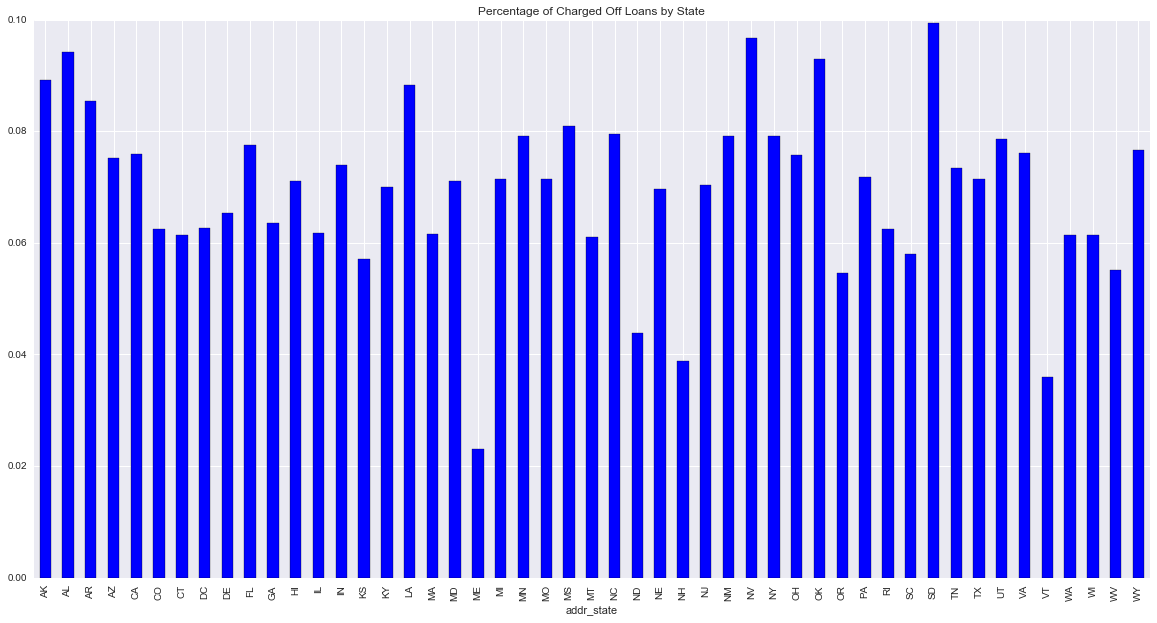

In [45]:
aax = norm_status_counts["Charged Off"].plot(figsize=(20,10),kind="bar")
_=ax.set_title("Percentage of Charged Off Loans by State")

We observe five fold variation in the percentage of loans that have been Charged Off from state to state. We can examine whether these apparent differences represent a significant increase in risk to being Charged Off as opposed to fully paid. 

In [73]:
chi2_stats(status_counts[["Charged Off", "Fully Paid"]].ix[["ME","TN"]])

,Cohort Stats
DoF,1.000
ME/TN_Fully Paid/Charged Off_lci,0.690
ME/TN_Fully Paid/Charged Off_risk,1.180
ME/TN_Fully Paid/Charged Off_uci,2.010
p-value,0.008


In [76]:
chi2_stats(status_counts[["Charged Off", "Fully Paid"]].ix[["ME","TN"]])

,Cohort Stats
DoF,1.000
ME/TN_Fully Paid/Charged Off_lci,0.690
ME/TN_Fully Paid/Charged Off_risk,1.180
ME/TN_Fully Paid/Charged Off_uci,2.010
p-value,0.008


For the most extreme pair of ME and TN we applied Chi2 analysis and computed relative the relative risk ratio with 95% confidence intervals. While there is a significant association between the two states and the final status of your loan, the effect size as measured by relative risk does not find a significant effect size. The lower 95% confidence interval is below 1. 

## Are there significant differences in the earliest credit line, annual income and interest rate between Fully Paid and Charged Off? ##

In [90]:
reduced_features = la.loan_data.query("loan_status=='Charged Off'| loan_status=='Fully Paid'")[["loan_status","annual_inc","earliest_cr_line","int_rate"]]

paid_features = reduced_features.query("loan_status=='Fully Paid'").drop("loan_status",axis=1)
charged_off_features = reduced_features.query("loan_status=='Charged Off'").drop("loan_status",axis=1)


paid_features.describe()

,annual_inc,earliest_cr_line,int_rate
count,88841.000000,88841.000000,88841.000000
mean,79507.256459,226.444729,12.558444
std,70663.392959,88.603598,4.306676
min,5000.000000,62.133333,5.320000
25%,49000.000000,171.700000,9.170000
50%,68000.000000,208.233333,12.290000
75%,95000.000000,269.100000,15.410000
max,7600000.000000,816.966667,28.990000


In [91]:
charged_off_features.describe()

,annual_inc,earliest_cr_line,int_rate
count,30586.000000,30586.000000,30586.000000
mean,69883.489924,216.814210,15.604064
std,87493.122074,89.735949,4.441526
min,4000.000000,62.133333,5.320000
25%,42500.000000,159.533333,12.590000
50%,60000.000000,196.033333,15.600000
75%,83270.700000,256.933333,18.250000
max,8900060.000000,804.800000,28.990000


We observe that fully paid loans on average have a higher annual income, have had a credit line longer, and have experienced a lower interest rate on their loans. We can use a two-sided t-test to determine if there are significant differences in these features between fully paid and charged off. 

In [94]:
{"annual_inc_p_value":ttest_ind(paid_features["annual_inc"],charged_off_features["annual_inc"]).pvalue,
 "earliest_cr_line_p_value":ttest_ind(paid_features["earliest_cr_line"],charged_off_features["earliest_cr_line"]).pvalue,
  "int_rate_p_value":ttest_ind(paid_features["int_rate"],charged_off_features["int_rate"]).pvalue}
 

{'annual_inc_p_value': 1.2842335071861241e-82,
 'earliest_cr_line_p_value': 5.8204402897837733e-60,
 'int_rate_p_value': 0.0}

We find that all three features have t-test p-values well below 0.01, therefore we reject the null hypothesis that there is no difference between the two groups. 

## Are there features that are correlated wtih the assigned sub-grade?##

In [2]:
la.loan_data[["dti","revol_util","revol_bal","earliest_cr_line","emp_length","installment","int_rate","sub_grade"]].corr("kendall")

,dti,revol_util,revol_bal,earliest_cr_line,emp_length,installment,int_rate,sub_grade
dti,1.000000,0.111155,0.159974,0.025141,0.014647,0.016473,0.142466,0.144118
revol_util,0.111155,1.000000,0.291262,0.014374,0.025418,0.092701,0.148130,0.149101
revol_bal,0.159974,0.291262,1.000000,0.189124,0.093148,0.333622,-0.052569,-0.053250
earliest_cr_line,0.025141,0.014374,0.189124,1.000000,0.127758,0.114525,-0.101522,-0.103353
emp_length,0.014647,0.025418,0.093148,0.127758,1.000000,0.074949,-0.011322,-0.011585
installment,0.016473,0.092701,0.333622,0.114525,0.074949,1.000000,0.071278,0.071153
int_rate,0.142466,0.148130,-0.052569,-0.101522,-0.011322,0.071278,1.000000,0.988368
sub_grade,0.144118,0.149101,-0.053250,-0.103353,-0.011585,0.071153,0.988368,1.000000


    We find that the sub_grade and interest rate are highly related (kendal tay 0.98), suggesting that encode equivalent information about the loan risk. We do not find that features related to the debt such as the resolving balance of utilization or the debt to income ratio are significantly correlated with sub_grade. We observed dti and revol_util have low kendall correlations with sub_grade. 

## Does the loan purpose increase your risk for Charge Off? ##

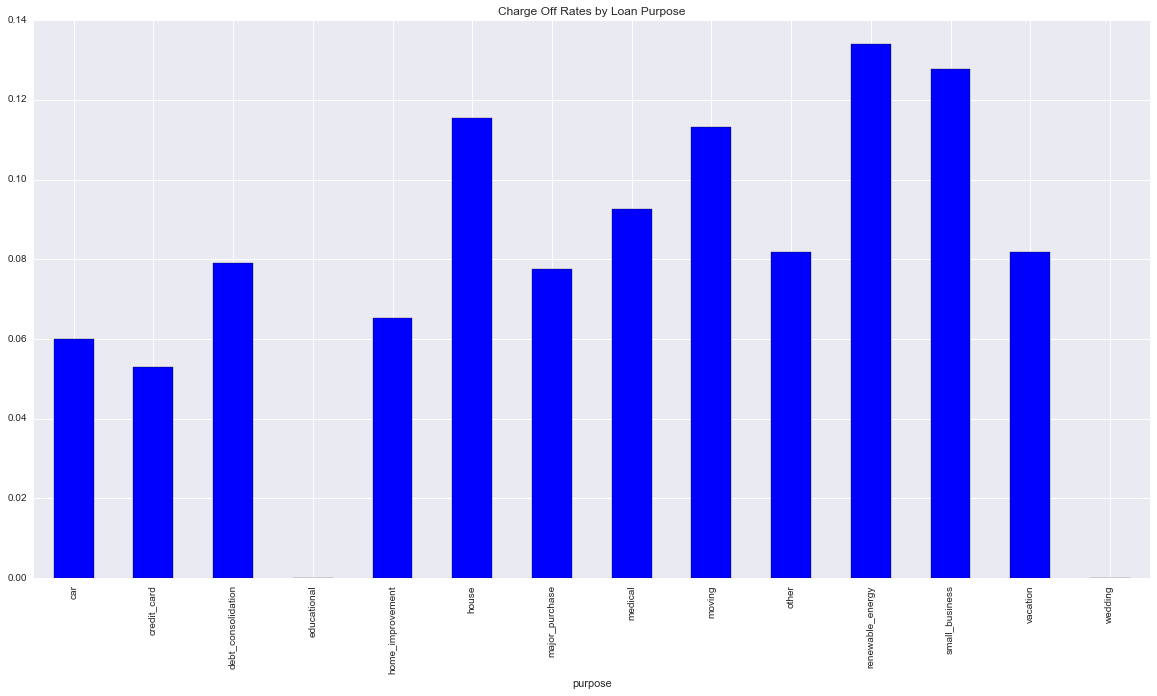

In [71]:
purpose_status = la.original_data[["purpose","loan_status"]].groupby(["purpose","loan_status"]).size().unstack().fillna(0)
purpose_status_normed = purpose_status.div(purpose_status.sum(axis=1),axis=0)
ax = purpose_status_normed["Charged Off"].plot(figsize=(20,10),kind="bar")
_= ax.set_title("Charge Off Rates by Loan Purpose")



Education and Wedding are underepresented in the data. Of the purposes that are represented in the data, purposes relating to credit cards and debt consolidation appear to be lower risk while those relating to renewabe energy and small businesses appear to be higher risk.  Again, we can apply Chi2 analysis and compute risk ratios to see if there are significant differences in the risk 

In [74]:
chi2_stats(purpose_status[["Charged Off", "Fully Paid"]].ix[["car","small_business"]])

,Cohort Stats
DoF,1.00
car/small_business_Fully Paid/Charged Off_lci,1.15
car/small_business_Fully Paid/Charged Off_risk,1.32
car/small_business_Fully Paid/Charged Off_uci,1.52
p-value,0.00


In [75]:
chi2_stats(purpose_status[["Charged Off", "Fully Paid"]].ix[["credit_card","small_business"]])

,Cohort Stats
DoF,1.00
credit_card/small_business_Fully Paid/Charged Off_lci,1.19
credit_card/small_business_Fully Paid/Charged Off_risk,1.28
credit_card/small_business_Fully Paid/Charged Off_uci,1.38
p-value,0.00


There is a significant association between wehther your purpose is credit_card or small_business and the outcome of your loan.  There is a similarly significant association for car and small business. In terms of effect size, for both credit card and car you are about 1.3 times more likely to be Fully Paid than Charged Off. 